# Working code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interact
import ipywidgets as widgets

# Load the dataset
file_path = 'Updated_Merged_Data.csv'
data = pd.read_csv(file_path)

# List of remote sensing variables
remote_sensing_vars = [col for col in data.columns if '_B' in col]

# List of average variables
avg_vars = ['B2_AVG', 'B3_AVG', 'B4_AVG', 'B8_AVG', 'B8A_AVG', 'B11_AVG', 'B12_AVG']

def plot_data(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero):
    plt.figure(figsize=(15, 6))
    
    # Evaluate the custom variable expression if provided
    if custom_var_expr:
        try:
            data['custom_var'] = eval(custom_var_expr, {"data": data, "np": np})
            x_var = 'custom_var'
        except Exception as e:
            print(f"Error in custom variable expression: {e}")
            return
    
    # Determine if the selected variable is a remote sensing variable or average variable
    is_remote_sensing = any(var in remote_sensing_vars for var in [x_var, y_var])
    is_avg = any(var in avg_vars for var in [x_var, y_var])
    
    # Always include the timestamp column for time series plotting
    cols_to_select = ['timestamp_sentinel2', x_var]
    if y_var != 'None':
        cols_to_select.append(y_var)
    if is_remote_sensing or is_avg:
        if is_avg:
            cs_col = 'cs_AVG'
            cdf_col = 'cs_cdf_AVG'
        else:
            point_num = x_var.split('_')[0].replace('point', '')
            cs_col = f'point{point_num}_cs'
            cdf_col = f'point{point_num}_cs_cdf'
        
        # Determine the appropriate column based on cloud_band selection
        if cloud_band == 'cs':
            filter_col = cs_col
        else:
            filter_col = cdf_col
        
        cols_to_select.append(filter_col)
        
        # Filter out rows with NaN values in the selected columns
        plot_data = data[cols_to_select].dropna()
        
        # Apply cloud score filtering if enabled
        if filter_cloud:
            plot_data = plot_data[plot_data[filter_col] >= cloud_threshold]
    else:
        # Filter out rows with NaN values in the selected columns without cloud score filtering
        plot_data = data[cols_to_select].dropna()
    
    # Drop zero-valued data points if enabled
    if drop_zero:
        plot_data = plot_data[plot_data[x_var] != 0]
        if y_var != 'None':
            plot_data = plot_data[plot_data[y_var] != 0]
    
    # Add a small positive constant to avoid log(0) or negative values
    epsilon = 1e-10
    
    # Take the logarithm of the values if enabled
    if log_x:
        plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
    if y_var != 'None' and log_y:
        plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
    
    if plot_type == 'Scatter Plot':
        if y_var != 'None':
            plt.scatter(plot_data[x_var], plot_data[y_var], alpha=0.5)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            
            # Calculate and display the correlation
            correlation = plot_data[[x_var, y_var]].corr().iloc[0, 1]
            plt.title(f'{plot_type} of {x_var} and {y_var}\nCorrelation: {correlation:.2f}')
        else:
            plt.scatter(plot_data.index, plot_data[x_var], alpha=0.5)
            plt.xlabel('Index')
            plt.ylabel(x_var)
            plt.title(f'{plot_type} of {x_var}')
        
    elif plot_type == 'Time Series Plot':
        if y_var != 'None':
            fig, ax1 = plt.subplots(figsize=(15, 6))
            color = 'tab:blue'
            ax1.set_xlabel('Time')
            ax1.set_ylabel(x_var, color=color)
            ax1.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), color=color, label=f'{x_var} (Moving Average)')
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel(y_var, color=color)
            ax2.plot(plot_data['timestamp_sentinel2'], plot_data[y_var].rolling(window=window).mean(), color=color, label=f'{y_var} (Moving Average)')
            ax2.tick_params(axis='y', labelcolor=color)
            
            fig.legend(loc='upper right')
            plt.title(f'{plot_type} of {x_var} and {y_var}')
        else:
            plt.figure(figsize=(15, 6))
            plt.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), label=f'{x_var} (Moving Average)')
            plt.xlabel('Time')
            plt.ylabel(x_var)
            plt.legend()
            plt.title(f'{plot_type} of {x_var}')
            
        # Adjust x-ticks to plot fewer of them, showing year and month only
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()
            
    plt.grid(True)
    plt.show()

variables = data.columns.tolist()
if 'timestamp_sentinel2' in variables:
    variables.remove('timestamp_sentinel2')

interact(plot_data, 
         plot_type=widgets.RadioButtons(options=['Scatter Plot', 'Time Series Plot'], description='Plot Type'),
         x_var=widgets.Dropdown(options=variables, description='X Variable'),
         y_var=widgets.Dropdown(options=['None'] + variables, description='Y Variable'),
         log_x=widgets.Checkbox(value=False, description='Log X Variable'),
         log_y=widgets.Checkbox(value=False, description='Log Y Variable'),
         window=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Moving Avg Window'),
         filter_cloud=widgets.Checkbox(value=False, description='Filter by Cloud Score'),
         cloud_band=widgets.RadioButtons(options=['cs', 'cs_cdf'], description='Cloud Band'),
         cloud_threshold=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Cloud Threshold'),
         custom_var_expr=widgets.Text(value='', description='Custom Var Expr'),
         drop_zero=widgets.Checkbox(value=False, description='Drop Zero Values')
);


interactive(children=(RadioButtons(description='Plot Type', options=('Scatter Plot', 'Time Series Plot'), valu…

interactive(children=(RadioButtons(description='Plot Type', options=('Scatter Plot', 'Time Series Plot'), valu…

<Figure size 1500x600 with 0 Axes>

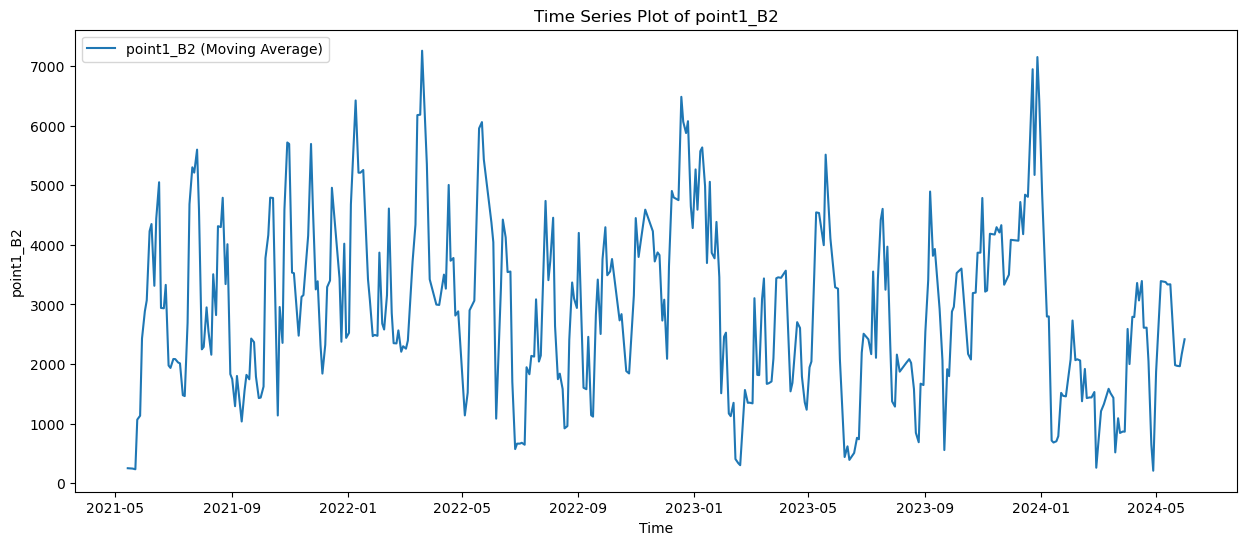

<Figure size 1500x600 with 0 Axes>

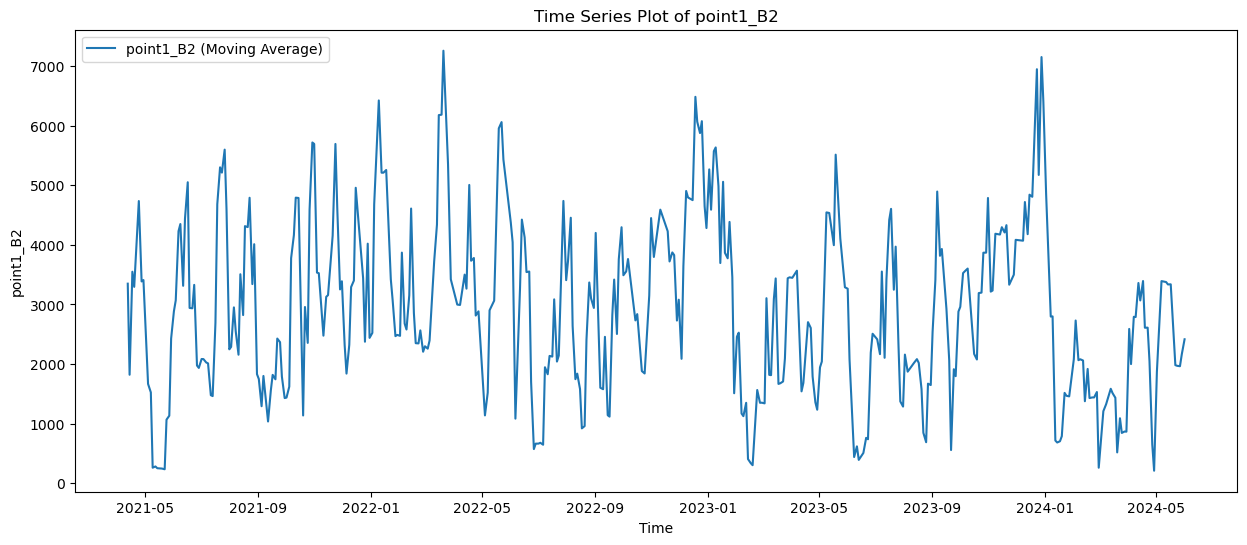

<Figure size 1500x600 with 0 Axes>

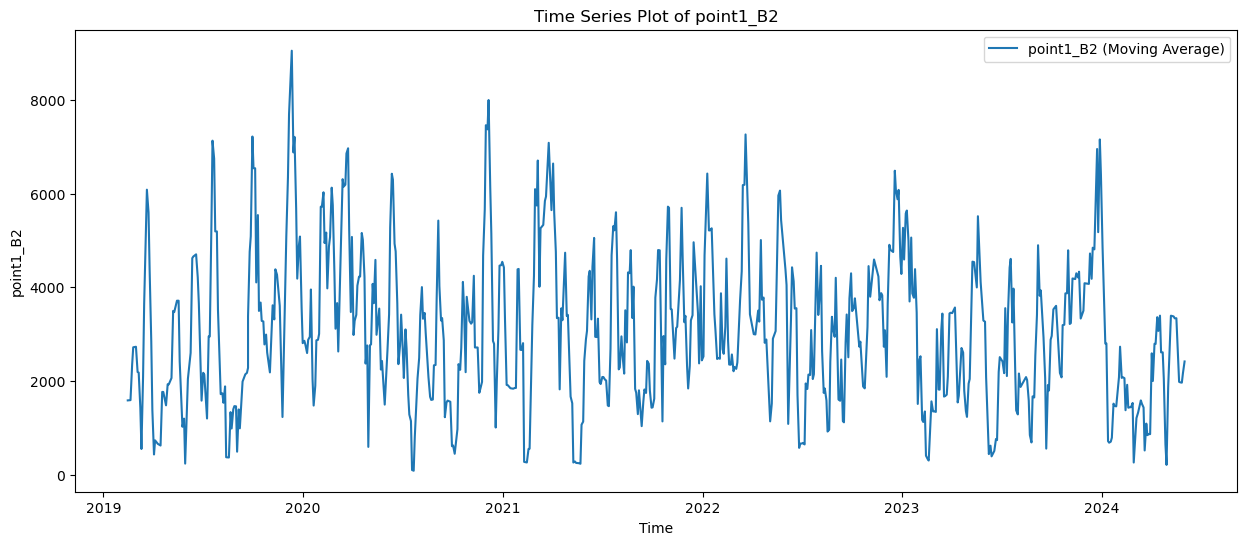

<Figure size 1500x600 with 0 Axes>

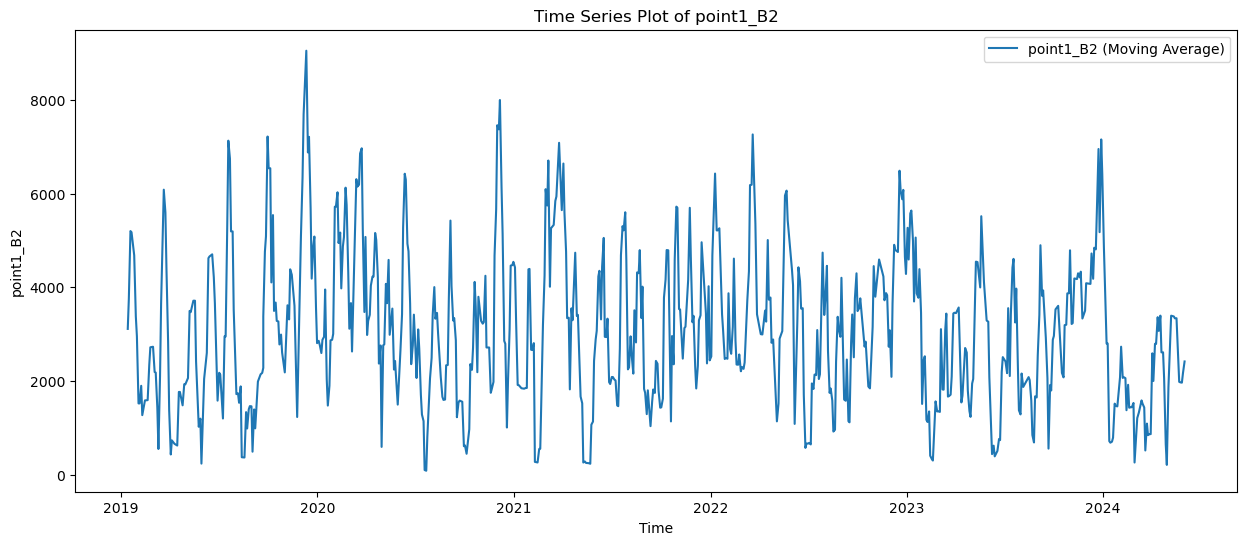

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interact, widgets
from datetime import datetime

# Load the dataset
file_path = 'Updated_Merged_Data.csv'
data = pd.read_csv(file_path)
data['timestamp_sentinel2'] = pd.to_datetime(data['timestamp_sentinel2'])

# List of remote sensing variables
remote_sensing_vars = [col for col in data.columns if '_B' in col]

# List of average variables
avg_vars = ['B2_AVG', 'B3_AVG', 'B4_AVG', 'B8_AVG', 'B8A_AVG', 'B11_AVG', 'B12_AVG']

# Function to filter the data based on cloud score and other filters
def filter_data(df, x_var, y_var, filter_cloud, cloud_band, cloud_threshold, drop_zero, log_x, log_y, log_threshold):
    # Determine if the selected variable is a remote sensing variable or average variable
    is_remote_sensing = any(var in remote_sensing_vars for var in [x_var, y_var])
    is_avg = any(var in avg_vars for var in [x_var, y_var])
    
    # Always include the timestamp column for time series plotting
    cols_to_select = ['timestamp_sentinel2', x_var]
    if y_var != 'None':
        cols_to_select.append(y_var)
    if is_remote_sensing or is_avg:
        if is_avg:
            cs_col = 'cs_AVG'
            cdf_col = 'cs_cdf_AVG'
        else:
            point_num = x_var.split('_')[0].replace('point', '')
            cs_col = f'point{point_num}_cs'
            cdf_col = f'point{point_num}_cs_cdf'
        
        # Determine the appropriate column based on cloud_band selection
        filter_col = cs_col if cloud_band == 'cs' else cdf_col
        cols_to_select.append(filter_col)
        
        # Filter out rows with NaN values in the selected columns
        plot_data = df[cols_to_select].dropna()
        
        # Apply cloud score filtering if enabled
        if filter_cloud:
            plot_data = plot_data[plot_data[filter_col] >= cloud_threshold]
    else:
        # Filter out rows with NaN values in the selected columns without cloud score filtering
        plot_data = df[cols_to_select].dropna()
    
    # Drop zero-valued data points if enabled
    if drop_zero:
        plot_data = plot_data[(plot_data[x_var] != 0)]
        if y_var != 'None':
            plot_data = plot_data[(plot_data[y_var] != 0)]
    
    # Add a small positive constant to avoid log(0) or negative values
    epsilon = 1e-10
    
    # Take the logarithm of the values if enabled
    if log_x:
        plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
    if y_var != 'None' and log_y:
        plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
    
    # Filter out nearly zero values after log transformation interactively
    plot_data = plot_data[plot_data[x_var] > log_threshold]
    if y_var != 'None':
        plot_data = plot_data[plot_data[y_var] > log_threshold]
    
    return plot_data

# Function to plot data
def plot_data(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero, log_threshold, start_date, end_date):
    plt.figure(figsize=(15, 6))
    
    # Apply custom variable expression if provided
    if custom_var_expr:
        try:
            data['custom_var'] = eval(custom_var_expr, {"data": data, "np": np})
            x_var = 'custom_var'
        except Exception as e:
            print(f"Error in custom variable expression: {e}")
            return
    
    # Filter data
    plot_data = filter_data(data, x_var, y_var, filter_cloud, cloud_band, cloud_threshold, drop_zero, log_x, log_y, log_threshold)
    
    # Apply date range filter
    if start_date and end_date:
        plot_data = plot_data[(plot_data['timestamp_sentinel2'] >= start_date) & (plot_data['timestamp_sentinel2'] <= end_date)]
    
    if plot_type == 'Scatter Plot':
        if y_var != 'None':
            plt.scatter(plot_data[x_var], plot_data[y_var], alpha=0.5)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            
            # Calculate and display the correlation
            correlation = plot_data[[x_var, y_var]].corr().iloc[0, 1]
            plt.title(f'{plot_type} of {x_var} and {y_var}\nCorrelation: {correlation:.2f}')
        else:
            plt.scatter(plot_data.index, plot_data[x_var], alpha=0.5)
            plt.xlabel('Index')
            plt.ylabel(x_var)
            plt.title(f'{plot_type} of {x_var}')
        
    elif plot_type == 'Time Series Plot':
        if y_var != 'None':
            fig, ax1 = plt.subplots(figsize=(15, 6))
            color = 'tab:blue'
            ax1.set_xlabel('Time')
            ax1.set_ylabel(x_var, color=color)
            ax1.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), color=color, label=f'{x_var} (Moving Average)')
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel(y_var, color=color)
            ax2.plot(plot_data['timestamp_sentinel2'], plot_data[y_var].rolling(window=window).mean(), color=color, label=f'{y_var} (Moving Average)')
            ax2.tick_params(axis='y', labelcolor=color)
            
            fig.legend(loc='upper right')
            plt.title(f'{plot_type} of {x_var} and {y_var}')
        else:
            plt.figure(figsize=(15, 6))
            plt.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), label=f'{x_var} (Moving Average)')
            plt.xlabel('Time')
            plt.ylabel(x_var)
            plt.legend()
            plt.title(f'{plot_type} of {x_var}')
            
        # Adjust x-ticks to plot fewer of them, showing year and month only
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()
            
    plt.grid(True)
    plt.show()

variables = data.columns.tolist()
if 'timestamp_sentinel2' in variables:
    variables.remove('timestamp_sentinel2')

# Interactive plot function
def interactive_plot(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero, log_threshold, date_range):
    start_date, end_date = convert_date_range_to_datetime(date_range)
    plot_data(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero, log_threshold, start_date, end_date)

# Define the date range slider
date_range_slider = widgets.SelectionRangeSlider(
    options=[(date.strftime('%Y-%m'), date) for date in pd.date_range(data['timestamp_sentinel2'].min(), data['timestamp_sentinel2'].max(), freq='MS')],
    index=(0, len(pd.date_range(data['timestamp_sentinel2'].min(), data['timestamp_sentinel2'].max(), freq='MS')) - 1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '800px'}
)

# Convert the date range slider values to datetime
def convert_date_range_to_datetime(date_range):
    return (pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))

interact(interactive_plot, 
         plot_type=widgets.RadioButtons(options=['Scatter Plot', 'Time Series Plot'], description='Plot Type'),
         x_var=widgets.Dropdown(options=variables, description='X Variable'),
         y_var=widgets.Dropdown(options=['None'] + variables, description='Y Variable'),
         log_x=widgets.Checkbox(value=False, description='Log X Variable'),
         log_y=widgets.Checkbox(value=False, description='Log Y Variable'),
         window=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Moving Avg Window'),
         filter_cloud=widgets.Checkbox(value=False, description='Filter by Cloud Score'),
         cloud_band=widgets.RadioButtons(options=['cs', 'cs_cdf'], description='Cloud Band'),
         cloud_threshold=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Cloud Threshold'),
         custom_var_expr=widgets.Text(value='', description='Custom Var Expr'),
         drop_zero=widgets.Checkbox(value=False, description='Drop Zero Values'),
         log_threshold=widgets.FloatSlider(value=np.log(1 + 1e-10), min=-10.0, max=1.0, step=0.01, description='Log Threshold'),
         date_range=date_range_slider
);



In [3]:
pip install bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, CustomJS, LinearAxis, Range1d
from bokeh.io import push_notebook
from ipywidgets import interact, widgets
from datetime import datetime

# Load the dataset
file_path = 'Updated_Merged_Data.csv'
data = pd.read_csv(file_path)
data['timestamp_sentinel2'] = pd.to_datetime(data['timestamp_sentinel2'])

# List of remote sensing variables
remote_sensing_vars = [col for col in data.columns if '_B' in col]

# List of average variables
avg_vars = ['B2_AVG', 'B3_AVG', 'B4_AVG', 'B8_AVG', 'B8A_AVG', 'B11_AVG', 'B12_AVG']

output_notebook()

def filter_data(df, x_var, y_var, filter_cloud, cloud_band, cloud_threshold, drop_zero, log_x, log_y):
    # Determine if the selected variable is a remote sensing variable or average variable
    is_remote_sensing = any(var in remote_sensing_vars for var in [x_var, y_var])
    is_avg = any(var in avg_vars for var in [x_var, y_var])
    
    # Always include the timestamp column for time series plotting
    cols_to_select = ['timestamp_sentinel2', x_var]
    if y_var != 'None':
        cols_to_select.append(y_var)
    if is_remote_sensing or is_avg:
        if is_avg:
            cs_col = 'cs_AVG'
            cdf_col = 'cs_cdf_AVG'
        else:
            point_num = x_var.split('_')[0].replace('point', '')
            cs_col = f'point{point_num}_cs'
            cdf_col = f'point{point_num}_cs_cdf'
        
        # Determine the appropriate column based on cloud_band selection
        filter_col = cs_col if cloud_band == 'cs' else cdf_col
        cols_to_select.append(filter_col)
        
        # Filter out rows with NaN values in the selected columns
        plot_data = df[cols_to_select].dropna()
        
        # Apply cloud score filtering if enabled
        if filter_cloud:
            plot_data = plot_data[plot_data[filter_col] >= cloud_threshold]
    else:
        # Filter out rows with NaN values in the selected columns without cloud score filtering
        plot_data = df[cols_to_select].dropna()
    
    # Drop zero-valued data points if enabled
    if drop_zero:
        plot_data = plot_data[(plot_data[x_var] != 0)]
        if y_var != 'None':
            plot_data = plot_data[(plot_data[y_var] != 0)]
    
    # Add a small positive constant to avoid log(0) or negative values
    epsilon = 1e-10
    
    # Take the logarithm of the values if enabled
    if log_x:
        plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
    if y_var != 'None' and log_y:
        plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
    
    return plot_data

def create_interactive_plots(x_var, y_var, log_x, log_y, filter_cloud, cloud_band, cloud_threshold, drop_zero, start_date, end_date):
    # Filter data
    filtered_data = filter_data(data, x_var, y_var, filter_cloud, cloud_band, cloud_threshold, drop_zero, log_x, log_y)
    
    # Apply date range filter
    if start_date and end_date:
        filtered_data = filtered_data[(filtered_data['timestamp_sentinel2'] >= start_date) & (filtered_data['timestamp_sentinel2'] <= end_date)]
    
    # Convert data to ColumnDataSource
    source = ColumnDataSource(filtered_data)
    
    # Create scatter plot
    scatter_plot = figure(width=800, height=400, title=f'Scatter Plot of {x_var} and {y_var}', tools="lasso_select,box_select,pan,wheel_zoom,reset")
    scatter_plot.scatter(x=x_var, y=y_var, source=source, alpha=0.5)
    
    # Calculate and display the correlation
    if y_var != 'None':
        correlation = filtered_data[[x_var, y_var]].corr().iloc[0, 1]
        scatter_plot.title.text += f'\nCorrelation: {correlation:.2f}'
    
    if log_x:
        scatter_plot.xaxis.axis_label = f'Log({x_var})'
    else:
        scatter_plot.xaxis.axis_label = x_var
    
    if log_y:
        scatter_plot.yaxis.axis_label = f'Log({y_var})'
    else:
        scatter_plot.yaxis.axis_label = y_var
    
    # Create time series plot
    time_series_plot = figure(width=800, height=400, x_axis_type="datetime", title=f'Time Series Plot of {x_var}', tools="xbox_select,pan,wheel_zoom,reset")
    time_series_plot.line('timestamp_sentinel2', x_var, source=source, color='blue')
    
    if y_var != 'None':
        time_series_plot.extra_y_ranges = {y_var: Range1d(start=filtered_data[y_var].min(), end=filtered_data[y_var].max())}
        time_series_plot.add_layout(LinearAxis(y_range_name=y_var), 'right')
        time_series_plot.line('timestamp_sentinel2', y_var, source=source, color='red', y_range_name=y_var)
    
    time_series_plot.xaxis.axis_label = 'Time'
    time_series_plot.yaxis.axis_label = x_var
    time_series_plot.xaxis.formatter = DatetimeTickFormatter(months="%b %Y")
    
    # Link selections
    scatter_plot.js_on_change('selected', CustomJS(args=dict(source=source), code="""
        var inds = cb_obj.indices;
        var data = source.data;
        for (var key in data) {
            data[key] = data[key].filter((_, i) => inds.includes(i));
        }
        source.change.emit();
    """))
    time_series_plot.js_on_change('selected', CustomJS(args=dict(source=source), code="""
        var inds = cb_obj.indices;
        var data = source.data;
        for (var key in data) {
            data[key] = data[key].filter((_, i) => inds.includes(i));
        }
        source.change.emit();
    """))
    
    # Show plots
    show(column(scatter_plot, time_series_plot), notebook_handle=True)

variables = data.columns.tolist()
if 'timestamp_sentinel2' in variables:
    variables.remove('timestamp_sentinel2')

# Define the date range slider
date_range_slider = widgets.SelectionRangeSlider(
    options=[(date.strftime('%Y-%m'), date) for date in pd.date_range(data['timestamp_sentinel2'].min(), data['timestamp_sentinel2'].max(), freq='MS')],
    index=(0, len(pd.date_range(data['timestamp_sentinel2'].min(), data['timestamp_sentinel2'].max(), freq='MS')) - 1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '800px'}
)

# Convert the date range slider values to datetime
def convert_date_range_to_datetime(date_range):
    return (pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))

def interactive_plot(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero, date_range):
    start_date, end_date = convert_date_range_to_datetime(date_range)
    create_interactive_plots(x_var, y_var, log_x, log_y, filter_cloud, cloud_band, cloud_threshold, drop_zero, start_date, end_date)

interact(interactive_plot, 
         plot_type=widgets.RadioButtons(options=['Scatter Plot', 'Time Series Plot'], description='Plot Type'),
         x_var=widgets.Dropdown(options=variables, description='X Variable'),
         y_var=widgets.Dropdown(options=['None'] + variables, description='Y Variable'),
         log_x=widgets.Checkbox(value=False, description='Log X Variable'),
         log_y=widgets.Checkbox(value=False, description='Log Y Variable'),
         window=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Moving Avg Window'),
         filter_cloud=widgets.Checkbox(value=False, description='Filter by Cloud Score'),
         cloud_band=widgets.RadioButtons(options=['cs', 'cs_cdf'], description='Cloud Band'),
         cloud_threshold=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Cloud Threshold'),
         custom_var_expr=widgets.Text(value='', description='Custom Var Expr'),
         drop_zero=widgets.Checkbox(value=False, description='Drop Zero Values'),
         date_range=date_range_slider
);


Loading BokehJS ...

interactive(children=(RadioButtons(description='Plot Type', options=('Scatter Plot', 'Time Series Plot'), valu…

In [1]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

p = figure(plot_width=400, plot_height=400)
p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)
show(p)


Loading BokehJS ...

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width